# Build a baseline model
For a baseline model, I would start with a Random Forest classifier. It is generally robust, performs well across a variety of datasets, and is less prone to overfitting compared to single decision trees. It also provides a good balance between performance and complexity.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set overall style parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'DejaVu Sans'

# load the dataset
data = pd.read_csv('../data/heart_featured.csv')

cat_cols = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 
            'RestingECG', 'ST_Slope', 'LawChol', 'LawOldpeak']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target_col = 'HeartDisease'

# check
data.shape

(918, 14)

Splitted 
Train shape: (642, 13), Val shape: (138, 13), Test shape: (138, 13)


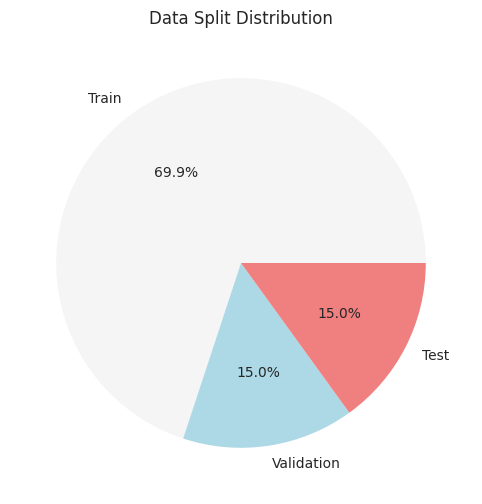

In [2]:
# Prepare features and target
y = data[target_col]
X = data.drop(columns=[target_col])

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Splitted \nTrain shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# Calculate percentages
total_samples = len(X_train) + len(X_val) + len(X_test)
train_pct = len(X_train) / total_samples * 100
val_pct = len(X_val) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie([train_pct, val_pct, test_pct], 
    labels=['Train', 'Validation', 'Test'],
    autopct='%1.1f%%',
    colors=['whitesmoke', 'lightblue', 'lightcoral'])
plt.title('Data Split Distribution')
plt.show()

In [3]:
# Encode categorical features for Random Forest
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[cat_cols])

def encode_and_concat(X):
    cat_encoded = encoder.transform(X[cat_cols])
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
    return pd.concat([X[num_cols].reset_index(drop=True), cat_encoded_df.reset_index(drop=True)], axis=1)

X_train_rf = encode_and_concat(X_train)
X_val_rf = encode_and_concat(X_val)
X_test_rf = encode_and_concat(X_test)

X_train_rf.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,LawChol_0,LawChol_1,LawOldpeak_0,LawOldpeak_1
0,52,140,259,170,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,53,123,282,95,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,53,120,274,130,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,51,150,200,120,0.5,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,59,130,318,120,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.8676
Validation Accuracy: 0.8260869565217391
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        62
           1       0.82      0.88      0.85        76

    accuracy                           0.83       138
   macro avg       0.83      0.82      0.82       138
weighted avg       0.83      0.83      0.82       138

Confusion Matrix:
 [[47 15]
 [ 9 67]]


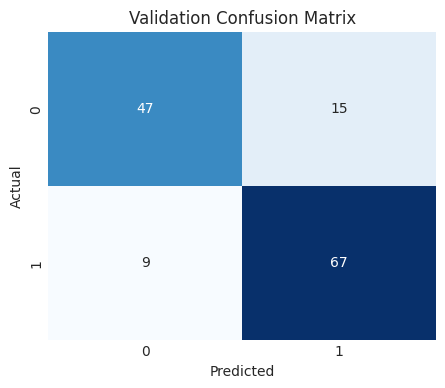

In [4]:
# Random Forest with Grid Search and Stratified K-Fold CV (using encoded data)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(rf, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train_rf, y_train)

print(f"Best parameters: {gs.best_params_}")
print(f"Best CV accuracy: {gs.best_score_:.4f}")

val_preds = gs.predict(X_val_rf)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

Test Accuracy: 0.8913043478260869
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88        62
           1       0.89      0.92      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138

Confusion Matrix:
 [[53  9]
 [ 6 70]]


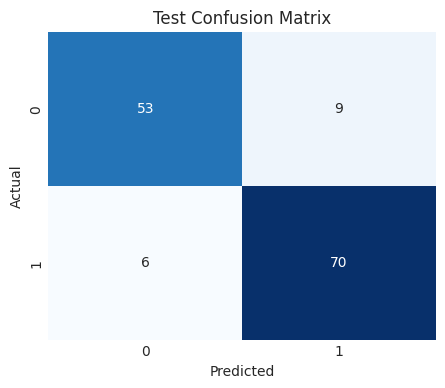

In [7]:
# Evaluate the best model on the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_preds = gs.predict(X_test_rf)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Classification Report:\n", classification_report(y_test, test_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

**Interpretation**
- The model achieves a high test accuracy (~89%), indicating strong generalization to unseen data.
- Both classes are predicted with high precision and recall, with slightly better recall for the positive class (1).
- The confusion matrix shows a low number of false positives and false negatives.
- The model's performance on the test set is even better than on the validation set, suggesting robust training and no overfitting.

**Final Suggestions**
- Consider analysing feature importances to gain insights into which variables are most influential.
- If even higher performance is needed, try more advanced models or ensemble techniques.
- Continue monitoring for data drift or changes if deploying in a real-world setting.
- Document and communicate these results to stakeholders for further decision-making.

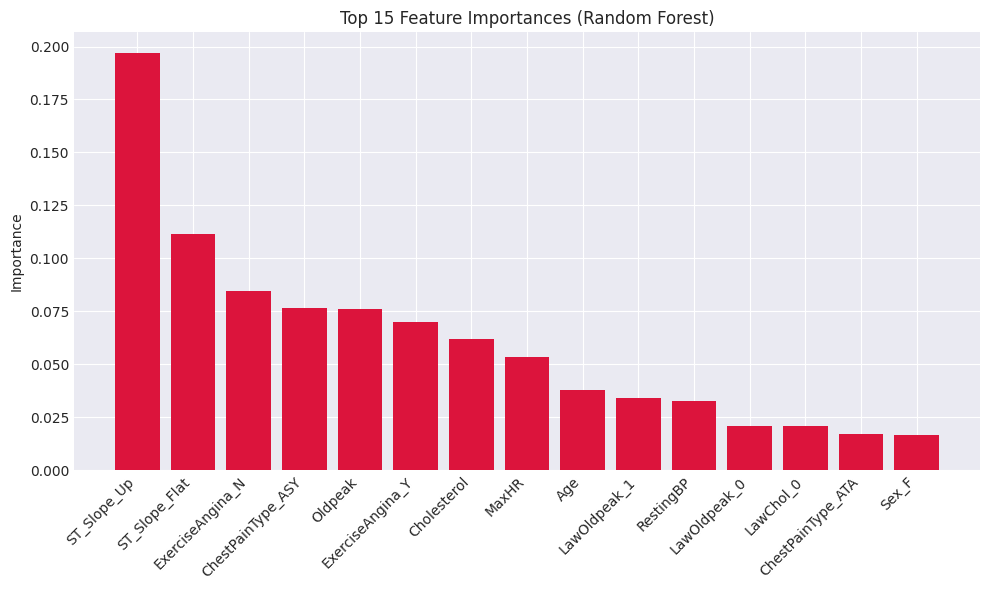

1. ST_Slope_Up: 0.1969
2. ST_Slope_Flat: 0.1117
3. ExerciseAngina_N: 0.0846
4. ChestPainType_ASY: 0.0766
5. Oldpeak: 0.0759
6. ExerciseAngina_Y: 0.0701
7. Cholesterol: 0.0617
8. MaxHR: 0.0535
9. Age: 0.0379
10. LawOldpeak_1: 0.0339
11. RestingBP: 0.0326
12. LawOldpeak_0: 0.0210
13. LawChol_0: 0.0207
14. ChestPainType_ATA: 0.0169
15. Sex_F: 0.0166
16. LawChol_1: 0.0155
17. ChestPainType_NAP: 0.0154
18. Sex_M: 0.0152
19. FastingBS_1: 0.0107
20. FastingBS_0: 0.0099
21. RestingECG_Normal: 0.0066
22. RestingECG_LVH: 0.0063
23. ST_Slope_Down: 0.0046
24. RestingECG_ST: 0.0028
25. ChestPainType_TA: 0.0025


In [8]:
# Analyze and plot feature importances
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best estimator
top_rf = gs.best_estimator_
importances = top_rf.feature_importances_
feature_names = list(X_train_rf.columns)

# Sort features by importance
dx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.bar(range(15), importances[dx][:15], align='center', color='crimson')
plt.xticks(range(15), [feature_names[i] for i in dx[:15]], rotation=45, ha='right')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Print all features
for i in range(25):
    print(f"{i+1}. {feature_names[dx[i]]}: {importances[dx[i]]:.4f}")

- **Most influential features:**  
  - `ST_Slope_Up` (0.1969) and `ST_Slope_Flat` (0.1117) are by far the most important, highlighting the predictive power of ST segment slope during exercise.
  - `ExerciseAngina_N` (0.0846) and `ExerciseAngina_Y` (0.0701) together indicate that the presence or absence of exercise-induced angina is a strong predictor.
  - `ChestPainType_ASY` (0.0766) and `Oldpeak` (0.0759) are also highly influential, aligning with clinical expectations.

- **Moderately important features:**  
  - `Cholesterol` (0.0617), `MaxHR` (0.0535), and `Age` (0.0379) contribute meaningfully, reflecting known cardiovascular risk factors.
  - Engineered features like `LawOldpeak_1` (0.0339), `RestingBP` (0.0326), `LawOldpeak_0` (0.0210), and `LawChol_0` (0.0207) also show moderate importance.
  - `ChestPainType_ATA` (0.0169), `Sex_F` (0.0166), `LawChol_1` (0.0155), `ChestPainType_NAP` (0.0154), and `Sex_M` (0.0152) have smaller but non-negligible contributions.

- **Least important features:**  
  - Features such as `FastingBS_1` (0.0107), `FastingBS_0` (0.0099), `RestingECG_Normal` (0.0066), `RestingECG_LVH` (0.0063), `ST_Slope_Down` (0.0046), `RestingECG_ST` (0.0028), and `ChestPainType_TA` (0.0025) have relatively low importance (<0.012).
  - These features contribute less to the model’s predictions, but their removal should only be considered if it does not reduce model performance.

**Summary & Suggestions**

- The model relies most on exercise-related ECG features and symptoms, which is consistent with medical knowledge.
- Demographic features (like sex) and fasting blood sugar have low importance in this dataset/model.
- Consider focusing on the most influential features for further analysis or model simplification.

In [9]:
# Save Random Forest model performance and feature importances to CSV
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
perf_rows = []
for split, X_, y_, preds in [
    ('validation', X_val_rf, y_val, val_preds),
    ('test', X_test_rf, y_test, test_preds),
    ]:
    perf_rows.append({
        'model': 'RandomForest',
        'split': split,
        'accuracy': accuracy_score(y_, preds),
        'precision': precision_score(y_, preds),
        'recall': recall_score(y_, preds),
        'f1': f1_score(y_, preds)
    })
perf_df = pd.DataFrame(perf_rows)
perf_df.to_csv('../data/model_performance.csv', mode='a', header=False, index=False)

# Save top 25 feature importances
fi_df = pd.DataFrame({
    'model': 'RandomForest',
    'feature': [feature_names[i] for i in dx[:25]],
    'importance': importances[dx[:25]]
})
fi_df.to_csv('../data/feature_importance.csv', mode='a', header=False, index=False)